<a href="https://colab.research.google.com/github/thalitazhrr/ML-CodonChronicle-/blob/main/Codon_Usage_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
# Enhanced Codon Clustering and Classification Pipeline
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
import os # Import os module for file path operations
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

In [97]:
# File ID from Google Drive
# https://drive.google.com/file/d/1QtwXZrkSKBiO31Btp1AJuPaIX3FUvO5r/view?usp=drive_link => File ID: 1QtwXZrkSKBiO31Btp1AJuPaIX3FUvO5r
# Penggunaan format berikut:
# https://drive.google.com/uc?id={file_id}

# Read File CSV
codon_data = pd.read_csv('https://drive.google.com/uc?id=1QtwXZrkSKBiO31Btp1AJuPaIX3FUvO5r',sep=',', low_memory=False)
codon_data

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [98]:
class ImprovedCodonClusteringPipeline:
    def __init__(self, codon_data):
        self.codon_data = codon_data.copy()
        self.codon_cols = codon_data.columns[5:]
        self.codon_to_aa = {
            'GCU': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
            'CGU': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R', 'AGA': 'R', 'AGG': 'R',
            'GGU': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G',
            'AAA': 'K', 'AAG': 'K',
            'UUU': 'F', 'UUC': 'F',
            'CCU': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
            'UCU': 'S', 'UCC': 'S', 'UCA': 'S', 'UCG': 'S', 'AGU': 'S', 'AGC': 'S',
            'AUU': 'I', 'AUC': 'I', 'AUA': 'I',
            'AUG': 'M',
            'GUU': 'V', 'GUC': 'V', 'GUA': 'V', 'GUG': 'V',
            'UUA': 'L', 'UUG': 'L', 'CUU': 'L', 'CUC': 'L', 'CUA': 'L', 'CUG': 'L',
            'ACU': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
            'UAU': 'Y', 'UAC': 'Y',
            'UAA': 'Stop', 'UAG': 'Stop', 'UGA': 'Stop',
            'CAA': 'Q', 'CAG': 'Q',
            'AAU': 'N', 'AAC': 'N',
            'GAU': 'D', 'GAC': 'D',
            'UGU': 'C', 'UGC': 'C',
            'GAA': 'E', 'GAG': 'E',
            'CAU': 'H', 'CAC': 'H',
            'UGG': 'W'  # Added missing Tryptophan
        }

        # Group amino acids by properties for better feature engineering
        self.aa_properties = {
            'hydrophobic': ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W'],
            'polar': ['S', 'T', 'N', 'Q', 'C'],
            'charged_positive': ['K', 'R', 'H'],
            'charged_negative': ['D', 'E'],
            'special': ['G', 'P']
        }

        self.features_log = None
        self.X_pca = None
        self.X_scaled = None
        self.outliers_mask = None

    def clean_data(self, fill_na=True, remove_outliers=True):
        """Enhanced data cleaning with outlier detection"""
        # Duplicate check
        dup_count = self.codon_data.duplicated().sum()
        print(f"Duplicate Rows: {dup_count}")

        # Remove duplicates
        self.codon_data = self.codon_data.drop_duplicates()

        # Convert to numeric & fill missing
        for col in self.codon_cols:
            self.codon_data[col] = pd.to_numeric(self.codon_data[col], errors='coerce')

        if fill_na:
            # Use median instead of mean for better outlier handling
            numeric_cols = self.codon_data.select_dtypes(include=np.number).columns
            self.codon_data[numeric_cols] = self.codon_data[numeric_cols].fillna(
                self.codon_data[numeric_cols].median()
            )

        # Remove rows with all zeros (likely corrupted data)
        codon_sum = self.codon_data[self.codon_cols].sum(axis=1)
        self.codon_data = self.codon_data[codon_sum > 0]

        print(f"Data shape after cleaning: {self.codon_data.shape}")
        return self

    def aggregate_codon_to_aa(self):
        """Enhanced aggregation with better handling"""
        aa_features = {}
        for codon, aa in self.codon_to_aa.items():
            if aa == 'Stop':
                continue
            if codon in self.codon_cols:
                aa_features.setdefault(aa, []).append(self.codon_data[codon])

        df_aa = pd.DataFrame()
        for aa, cols in aa_features.items():
            df_aa[aa] = np.sum(cols, axis=0)

        self.df_aa = df_aa
        return self

    def normalize_per_row(self):
        """Enhanced normalization with pseudocount"""
        # Add pseudocount to avoid division by zero and log(0)
        pseudocount = 1e-8
        row_sums = self.df_aa.sum(axis=1)

        # Filter out rows with very low counts (likely noise)
        valid_rows = row_sums > row_sums.quantile(0.05)  # Remove bottom 5%
        self.df_aa = self.df_aa[valid_rows]
        self.codon_data = self.codon_data[valid_rows]

        row_sums = self.df_aa.sum(axis=1)
        self.df_aa_norm = (self.df_aa + pseudocount).div(row_sums + pseudocount * len(self.df_aa.columns), axis=0)

        print(f"Data shape after filtering low-count rows: {self.df_aa_norm.shape}")
        return self

    def add_advanced_features(self):
        """Add more sophisticated features with robust NaN handling"""
        df = self.df_aa_norm
        stats = pd.DataFrame(index=df.index)

        # Basic statistics with NaN handling
        stats['mean'] = df.mean(axis=1)
        stats['median'] = df.median(axis=1)
        stats['std'] = df.std(axis=1).fillna(0)  # Fill NaN std with 0
        stats['skewness'] = df.skew(axis=1).fillna(0)  # Fill NaN skewness with 0
        stats['kurtosis'] = df.kurtosis(axis=1).fillna(0)  # Fill NaN kurtosis with 0

        # Entropy with better handling
        freq_norm = df.div(df.sum(axis=1), axis=0).fillna(0)
        stats['entropy'] = freq_norm.apply(lambda x: entropy(x + 1e-10, base=2), axis=1)
        stats['entropy'] = stats['entropy'].fillna(0)  # Fill NaN entropy with 0

        # Gini coefficient (measure of inequality) with NaN handling
        def gini_coefficient(x):
            try:
                x = np.array(x)
                x = x[~np.isnan(x)]  # Remove NaN values
                if len(x) == 0 or np.sum(x) == 0:
                    return 0
                x = np.sort(x)
                n = len(x)
                index = np.arange(1, n + 1)
                return (2 * np.sum(index * x)) / (n * np.sum(x)) - (n + 1) / n
            except:
                return 0

        stats['gini'] = df.apply(gini_coefficient, axis=1)

        # Amino acid property-based features with NaN handling
        for prop_name, aa_list in self.aa_properties.items():
            prop_cols = [aa for aa in aa_list if aa in df.columns]
            if prop_cols:
                stats[f'{prop_name}_usage'] = df[prop_cols].sum(axis=1)
                prop_entropy = df[prop_cols].apply(
                    lambda x: entropy(x + 1e-10, base=2) if len(x) > 0 and np.sum(x) > 0 else 0, axis=1
                )
                stats[f'{prop_name}_entropy'] = prop_entropy.fillna(0)

        # Codon usage bias indices
        self.calculate_codon_bias_indices(df, stats)

        # Final NaN check and fill
        stats = stats.fillna(0)

        self.stats = stats
        return self

    def calculate_codon_bias_indices(self, df, stats):
        """Calculate advanced codon usage bias indices with robust NaN handling"""
        # Effective Number of Codons (ENc) - approximation
        nc_values = []
        for idx in df.index:
            try:
                aa_usage = df.loc[idx]
                # Simple ENc approximation
                nc = 0
                for aa_group in self.aa_properties.values():
                    group_usage = [aa_usage.get(aa, 0) for aa in aa_group if aa in aa_usage.index]
                    if group_usage and sum(group_usage) > 0:
                        group_usage = np.array(group_usage)
                        group_usage = group_usage[~np.isnan(group_usage)]  # Remove NaN
                        if len(group_usage) > 0 and np.sum(group_usage) > 0:
                            group_usage = group_usage / group_usage.sum()
                            nc += 1 / max(np.sum(group_usage ** 2), 1e-10)  # Avoid division by zero
                nc_values.append(nc if not np.isnan(nc) and np.isfinite(nc) else 0)
            except:
                nc_values.append(0)

        stats['enc_approx'] = nc_values

        # Codon Adaptation Index (CAI) - simple version
        # Using high-expression genes pattern (simplified)
        reference_pattern = df.mean()  # Use mean as reference
        cai_values = []
        for idx in df.index:
            try:
                aa_usage = df.loc[idx]
                # Simplified CAI calculation with NaN handling
                ratio = aa_usage / (reference_pattern + 1e-10)
                ratio = ratio[~np.isnan(ratio)]  # Remove NaN values
                if len(ratio) > 0:
                    log_ratio = np.log(ratio + 1e-10)
                    log_ratio = log_ratio[np.isfinite(log_ratio)]  # Remove inf values
                    if len(log_ratio) > 0:
                        cai = np.exp(np.mean(log_ratio))
                        cai_values.append(cai if not np.isnan(cai) and np.isfinite(cai) else 1.0)
                    else:
                        cai_values.append(1.0)
                else:
                    cai_values.append(1.0)
            except:
                cai_values.append(1.0)

        stats['cai_approx'] = cai_values

    def add_cosine_similarity_feature(self):
        """Enhanced similarity features"""
        df = self.df_aa_norm

        # Similarity to mean profile
        mean_profile = df.mean(axis=0).values.reshape(1, -1)
        cos_sim_mean = cosine_similarity(df.values, mean_profile).flatten()

        # Similarity to median profile
        median_profile = df.median(axis=0).values.reshape(1, -1)
        cos_sim_median = cosine_similarity(df.values, median_profile).flatten()

        # Kingdom-specific similarities if available
        kingdom_sims = []
        if 'Kingdom' in self.codon_data.columns:
            for kingdom in self.codon_data['Kingdom'].unique():
                kingdom_mask = self.codon_data['Kingdom'] == kingdom
                if kingdom_mask.sum() > 1:
                    kingdom_profile = df[kingdom_mask].mean(axis=0).values.reshape(1, -1)
                    kingdom_sim = cosine_similarity(df.values, kingdom_profile).flatten()
                    kingdom_sims.append(pd.Series(kingdom_sim, index=df.index, name=f'cos_sim_{kingdom}'))

        similarity_features = pd.DataFrame({
            'cosine_similarity_to_mean': cos_sim_mean,
            'cosine_similarity_to_median': cos_sim_median
        }, index=df.index)

        # Add kingdom similarities
        for kingdom_sim in kingdom_sims:
            similarity_features[kingdom_sim.name] = kingdom_sim

        self.cos_sim = similarity_features
        return self

    def detect_and_handle_outliers(self, contamination=0.1):
        """Detect and optionally remove outliers"""
        if self.features is None:
            print("Features not yet combined. Skipping outlier detection.")
            return self

        # Use Isolation Forest for outlier detection
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        outlier_labels = iso_forest.fit_predict(self.features.select_dtypes(include=[np.number]))

        self.outliers_mask = outlier_labels == -1
        n_outliers = self.outliers_mask.sum()

        print(f"Detected {n_outliers} outliers ({n_outliers/len(self.features)*100:.2f}%)")

        # Option to remove outliers
        # self.features = self.features[~self.outliers_mask]
        # self.codon_data = self.codon_data[~self.outliers_mask]

        return self

    def combine_features(self):
        """Enhanced feature combination with robust NaN handling"""
        features = pd.concat([self.df_aa_norm, self.stats, self.cos_sim], axis=1)

        # Encode categorical variables
        if 'Kingdom' in self.codon_data.columns:
            le = LabelEncoder()
            kingdom_encoded = le.fit_transform(self.codon_data['Kingdom'])
            features['kingdom_encoded'] = kingdom_encoded

            # One-hot encode kingdom for better separation
            kingdom_dummies = pd.get_dummies(self.codon_data['Kingdom'], prefix='kingdom')
            features = pd.concat([features, kingdom_dummies], axis=1)

        # Add interaction features (selected pairs) with NaN handling
        if 'entropy' in features.columns and 'std' in features.columns:
            features['entropy_std_interaction'] = (features['entropy'] * features['std']).fillna(0)

        if 'mean' in features.columns and 'gini' in features.columns:
            features['mean_gini_interaction'] = (features['mean'] * features['gini']).fillna(0)

        # Handle all NaN values before variance filtering
        features = features.fillna(0)

        # Check for infinite values
        features = features.replace([np.inf, -np.inf], 0)

        # Remove features with very low variance
        numeric_features = features.select_dtypes(include=[np.number])
        if not numeric_features.empty:
            variance_selector = VarianceThreshold(threshold=1e-8)
            try:
                selected_mask = variance_selector.fit_transform(numeric_features)
                selected_features = numeric_features.loc[:, variance_selector.get_support()]
            except:
                # If variance threshold fails, use all numeric features
                selected_features = numeric_features

            # Combine with non-numeric features if any
            non_numeric = features.select_dtypes(exclude=[np.number])
            if not non_numeric.empty:
                features = pd.concat([selected_features, non_numeric], axis=1)
            else:
                features = selected_features

        # Final check for NaN and infinite values
        features = features.fillna(0)
        features = features.replace([np.inf, -np.inf], 0)

        self.features = features
        print(f"Final feature shape: {features.shape}")
        print(f"NaN count after processing: {features.isnull().sum().sum()}")
        return self

    def advanced_scaling(self, method='robust'):
        """Use different scaling methods"""
        if method == 'robust':
            scaler = RobustScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()

        self.X_scaled = scaler.fit_transform(self.features_log)
        print(f"Applied {method} scaling")
        return self

    def apply_pca(self, variance_threshold=0.85, max_components=None):
        """Enhanced PCA with better component selection"""
        if max_components is None:
            max_components = min(50, self.X_scaled.shape[1], self.X_scaled.shape[0] - 1)

        pca_temp = PCA()
        pca_temp.fit(self.X_scaled)
        cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)

        # Find optimal number of components
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        n_components = min(n_components, max_components, self.X_scaled.shape[1])
        n_components = max(1, n_components)

        print(f"PCA components to explain {variance_threshold*100}% variance: {n_components}")
        print(f"Actual variance explained: {cumulative_variance[n_components-1]*100:.2f}%")

        pca = PCA(n_components=n_components)
        self.X_pca = pca.fit_transform(self.X_scaled)
        self.pca_model = pca

        return self

    def run_advanced_clustering(self, min_clusters=2, max_clusters=15, methods=['kmeans', 'gmm']):
        """Enhanced clustering with multiple algorithms"""
        best_score = -1
        best_labels = None
        best_k = None
        best_method = None

        results = {}

        for method in methods:
            print(f"\n--- {method.upper()} Clustering ---")
            method_results = {}

            for k in range(min_clusters, min(max_clusters + 1, self.X_pca.shape[0])):
                try:
                    if method == 'kmeans':
                        model = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
                    elif method == 'gmm':
                        model = GaussianMixture(n_components=k, random_state=42, max_iter=200)
                    else:
                        continue

                    labels = model.fit_predict(self.X_pca)

                    # Skip if all points are in one cluster
                    if len(set(labels)) <= 1:
                        continue

                    score = silhouette_score(self.X_pca, labels)
                    method_results[k] = {'score': score, 'labels': labels, 'model': model}

                    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

                    if score > best_score:
                        best_score = score
                        best_labels = labels
                        best_k = k
                        best_method = method

                except Exception as e:
                    print(f"Error with {method} k={k}: {e}")
                    continue

            results[method] = method_results

        print(f"\n=== BEST RESULT ===")
        print(f"Method: {best_method}, Clusters: {best_k}, Score: {best_score:.4f}")

        self.clustering_results = results
        return best_labels, best_score, best_k, best_method

    def optimize_clustering_parameters(self):
        """Fine-tune clustering parameters"""
        print("Optimizing clustering parameters...")

        best_score = -1
        best_params = None
        best_labels = None

        # Try different initialization methods and parameters for K-means
        init_methods = ['k-means++', 'random']
        n_init_values = [20, 50]
        max_iter_values = [300, 500]

        # Find rough optimal k first
        silhouette_scores = []
        k_range = range(2, min(16, self.X_pca.shape[0]))

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(self.X_pca)
            if len(set(labels)) > 1:
                score = silhouette_score(self.X_pca, labels)
                silhouette_scores.append(score)
            else:
                silhouette_scores.append(-1)

        # Focus on top k values
        top_k_indices = np.argsort(silhouette_scores)[-3:]  # Top 3
        top_k_values = [k_range[i] for i in top_k_indices if silhouette_scores[i] > 0]

        print(f"Top K values to optimize: {top_k_values}")

        # Fine-tune parameters for top k values
        for k in top_k_values:
            for init_method in init_methods:
                for n_init in n_init_values:
                    for max_iter in max_iter_values:
                        try:
                            kmeans = KMeans(
                                n_clusters=k,
                                init=init_method,
                                n_init=n_init,
                                max_iter=max_iter,
                                random_state=42
                            )
                            labels = kmeans.fit_predict(self.X_pca)

                            if len(set(labels)) > 1:
                                score = silhouette_score(self.X_pca, labels)

                                if score > best_score:
                                    best_score = score
                                    best_labels = labels
                                    best_params = {
                                        'n_clusters': k,
                                        'init': init_method,
                                        'n_init': n_init,
                                        'max_iter': max_iter,
                                        'score': score
                                    }
                        except:
                            continue

        print(f"Best optimized parameters: {best_params}")
        return best_labels, best_score, best_params

    def full_pipeline(self,
                      fill_na=True,
                      remove_outliers=False,
                      do_aggregate=True,
                      do_normalize=True,
                      add_advanced_stats=True,
                      add_cosine=True,
                      detect_outliers=True,
                      do_log=True,
                      scaling_method='robust',
                      do_pca=True,
                      variance_threshold=0.85,
                      optimize_params=True):
        """Enhanced full pipeline with robust error handling"""

        print("=== ENHANCED CODON CLUSTERING PIPELINE ===")

        # Data cleaning
        self.clean_data(fill_na=fill_na, remove_outliers=remove_outliers)

        if do_aggregate:
            self.aggregate_codon_to_aa()

        if do_normalize:
            self.normalize_per_row()

        if add_advanced_stats:
            self.add_advanced_features()
        else:
            self.add_global_statistics()  # Fallback to basic stats

        if add_cosine:
            self.add_cosine_similarity_feature()

        self.combine_features()

        if detect_outliers:
            self.detect_and_handle_outliers()

        # Log transform with NaN handling
        if do_log:
            numeric_features = self.features.select_dtypes(include=[np.number])
            # Handle zeros and negative values before log transform
            numeric_features = numeric_features.clip(lower=0)  # Ensure no negative values
            self.features_log = np.log1p(numeric_features)
        else:
            self.features_log = self.features.select_dtypes(include=[np.number]).copy()

        # Final NaN check before scaling
        self.features_log = self.features_log.fillna(0)
        self.features_log = self.features_log.replace([np.inf, -np.inf], 0)

        print(f"Features shape before scaling: {self.features_log.shape}")
        print(f"NaN count before scaling: {self.features_log.isnull().sum().sum()}")
        print(f"Inf count before scaling: {np.isinf(self.features_log.values).sum()}")

        self.advanced_scaling(method=scaling_method)

        if do_pca and self.X_scaled.shape[0] > 1 and self.X_scaled.shape[1] > 0:
            self.apply_pca(variance_threshold=variance_threshold)
        else:
            self.X_pca = self.X_scaled

        print(f"\nFinal data shape for clustering: {self.X_pca.shape}")

        # Enhanced clustering
        if optimize_params:
            return self.optimize_clustering_parameters()
        else:
            return self.run_advanced_clustering()

    def visualize_clusters(self, method='tsne', labels=None, use_pca=True, title=None, figsize=(12, 8)):
        """Enhanced visualization"""
        X_input = self.X_pca if use_pca and self.X_pca is not None else self.X_scaled

        if X_input is None or X_input.shape[0] < 2:
            print(f"Skipping visualization ({method}): Insufficient data.")
            return

        plt.figure(figsize=figsize)

        if method == 'tsne':
            perplexity = min(30, max(2, X_input.shape[0] - 1))
            tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=1000)
            X_vis = tsne.fit_transform(X_input)
            title = title or "t-SNE Visualization"
        elif method == 'umap':
            n_neighbors = min(15, max(2, X_input.shape[0] - 1))
            reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42, min_dist=0.1)
            X_vis = reducer.fit_transform(X_input)
            title = title or "UMAP Visualization"
        else:
            raise ValueError("method must be 'tsne' or 'umap'")

        if labels is not None:
            scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, cmap='tab10', s=60, alpha=0.7)
            plt.colorbar(scatter, label="Cluster Labels")

            # Add cluster centers
            unique_labels = np.unique(labels)
            for label in unique_labels:
                if label == -1:  # Skip noise points in DBSCAN
                    continue
                mask = labels == label
                center_x = np.mean(X_vis[mask, 0])
                center_y = np.mean(X_vis[mask, 1])
                plt.scatter(center_x, center_y, c='red', marker='x', s=200, linewidths=3)
        else:
            plt.scatter(X_vis[:, 0], X_vis[:, 1], s=60, alpha=0.7)

        plt.title(title, fontsize=14)
        plt.xlabel(f'{method.upper()} 1', fontsize=12)
        plt.ylabel(f'{method.upper()} 2', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def analyze_clusters(self, labels, method_name="Clustering"):
        """Analyze cluster characteristics"""
        if labels is None:
            return

        print(f"\n=== {method_name} Analysis ===")
        unique_labels = np.unique(labels)
        print(f"Number of clusters: {len(unique_labels)}")

        for label in unique_labels:
            mask = labels == label
            count = mask.sum()
            percentage = count / len(labels) * 100
            print(f"Cluster {label}: {count} samples ({percentage:.1f}%)")

        # Analyze by Kingdom if available
        if 'Kingdom' in self.codon_data.columns:
            print("\nCluster composition by Kingdom:")
            df_analysis = pd.DataFrame({
                'Kingdom': self.codon_data['Kingdom'].values,
                'Cluster': labels
            })

            cluster_kingdom = pd.crosstab(df_analysis['Cluster'], df_analysis['Kingdom'], normalize='index') * 100
            print(cluster_kingdom.round(1))


# Usage example:
# pipeline = ImprovedCodonClusteringPipeline(codon_data)
# best_labels, best_score, best_params = pipeline.full_pipeline(optimize_params=True)
# pipeline.visualize_clusters(labels=best_labels)
# pipeline.analyze_clusters(best_labels, "Optimized K-means")

In [99]:
class CodonClassificationPipeline:
    def __init__(self, clustered_data, pipeline_object):
        """
        clustered_data: DataFrame dengan kolom cluster hasil dari clustering
        pipeline_object: Object ImprovedCodonClusteringPipeline yang sudah dijalankan
        """
        self.data = clustered_data.copy()
        self.pipeline_obj = pipeline_object
        self.codon_cols = [col for col in self.data.columns if col not in ['Species', 'Kingdom', 'Phylum', 'Class', 'Order', 'Cluster']]
        self.X = None
        self.y = None
        self.models = {}
        self.feature_importance = {}
        self.classification_results = {}

    def prepare_classification_data(self):
        print("=== PREPARING CLASSIFICATION DATA ===")
        if hasattr(self.pipeline_obj, 'features_log') and self.pipeline_obj.features_log is not None:
            self.X = self.pipeline_obj.features_log.reindex(self.data.index).dropna()
        else:
            self.X = self.data[self.codon_cols].copy().dropna()
        self.y = self.data.loc[self.X.index, 'Cluster'].copy()
        print(f"Feature shape: {self.X.shape}")
        print(f"Target distribution:")
        print(self.y.value_counts().sort_index())
        if not self.X.index.equals(self.y.index):
             raise IndexError("Index mismatch between features (X) and labels (y) after preparation!")
        return self

    def run_multiple_classifiers(self, test_size=0.2, random_state=42):
        print("\n=== RUNNING MULTIPLE CLASSIFIERS ===")
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=self.y
        )
        classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'XGBoost': xgb.XGBClassifier(random_state=random_state, eval_metric='mlogloss'),
            'SVM': SVC(random_state=random_state, probability=True),
            'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000)
        }
        results = {}
        for name, clf in classifiers.items():
            print(f"\nTraining {name}...")
            try:
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_pred_proba = clf.predict_proba(X_test) if hasattr(clf, 'predict_proba') else None
                accuracy = accuracy_score(y_test, y_pred)
                cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
                results[name] = {
                    'model': clf,
                    'accuracy': accuracy,
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'y_test': y_test,
                    'y_pred': y_pred,
                    'y_pred_proba': y_pred_proba
                }
                print(f"{name} - Accuracy: {accuracy:.4f}, CV: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
            except Exception as e:
                print(f"Error with {name}: {e}")
                continue
        self.classification_results = results
        return self

    def optimize_best_classifier(self, n_iter=20, cv=3):
        print("\n=== OPTIMIZING BEST CLASSIFIER ===")
        if not self.classification_results:
            print("No classification results found. Run run_multiple_classifiers() first.")
            return self
        best_name = max(self.classification_results.keys(),
                      key=lambda x: self.classification_results[x]['cv_mean'])
        print(f"Best classifier: {best_name}")
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )
        param_grids = {
            'Random Forest': {
                'n_estimators': [100, 200],
                'max_depth': [10, None],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            },
            'XGBoost': {
                'n_estimators': [100, 200],
                'max_depth': [3, 6],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.8, 1.0]
            },
            'SVM': {
                'C': [0.1, 1, 10],
                'gamma': ['scale'],
                'kernel': ['rbf']
            },
            'Logistic Regression': {
                'C': [0.1, 1, 10],
                'penalty': ['l2'],
                'solver': ['liblinear']
            }
        }
        if best_name in param_grids:
            print(f"Optimizing {best_name} with {n_iter} randomized search iterations...")
            if best_name == 'Random Forest':
                base_model = RandomForestClassifier(random_state=42)
            elif best_name == 'XGBoost':
                base_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
            elif best_name == 'SVM':
                base_model = SVC(random_state=42, probability=True)
            else:
                base_model = LogisticRegression(random_state=42, max_iter=1000)
            random_search = RandomizedSearchCV(
                base_model,
                param_distributions=param_grids[best_name],
                n_iter=n_iter,
                cv=cv,
                scoring='accuracy',
                n_jobs=-1,
                random_state=42
            )
            random_search.fit(X_train, y_train)
            best_model = random_search.best_estimator_
            y_pred = best_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Best parameters: {random_search.best_params_}")
            print(f"Optimized accuracy: {accuracy:.4f}")
            self.classification_results[f'{best_name}_Optimized'] = {
                'model': best_model,
                'accuracy': accuracy,
                'y_test': y_test,
                'y_pred': y_pred,
                'best_params': random_search.best_params_
            }
        return self

    def extract_feature_importance(self, top_n=20):
        print(f"\n=== EXTRACTING TOP {top_n} FEATURE IMPORTANCE ===")
        feature_names = self.X.columns
        for name, result in self.classification_results.items():
            model = result['model']
            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': importance
                }).sort_values('Importance', ascending=False)
                self.feature_importance[name] = importance_df
                print(f"\n{name} - Top {min(top_n, len(importance_df))} Important Features:")
                print(importance_df.head(top_n))
            elif hasattr(model, 'coef_'):
                if len(model.coef_.shape) > 1:
                    importance = np.mean(np.abs(model.coef_), axis=0)
                else:
                    importance = np.abs(model.coef_)
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': importance
                }).sort_values('Importance', ascending=False)
                self.feature_importance[name] = importance_df
                print(f"\n{name} - Top {min(top_n, len(importance_df))} Important Features:")
                print(importance_df.head(top_n))
        return self

    def analyze_cluster_characteristics(self):
            """Analisis karakteristik setiap cluster berdasarkan kodon"""
            print("\n=== ANALYZING CLUSTER CHARACTERISTICS ===")

            cluster_analysis = {}

            for cluster in sorted(self.y.unique()):
                cluster_mask = self.y == cluster
                cluster_data = self.X[cluster_mask]

                # Statistical summary
                cluster_stats = {
                    'mean': cluster_data.mean(),
                    'std': cluster_data.std(),
                    'size': cluster_mask.sum()
                }

                # Top features (highest mean values)
                top_features = cluster_stats['mean'].sort_values(ascending=False).head(10)

                cluster_analysis[cluster] = {
                    'stats': cluster_stats,
                    'top_features': top_features,
                    'size': cluster_stats['size']
                }

                print(f"\nCluster {cluster} ({cluster_stats['size']} samples):")
                print("Top features (highest mean):")
                print(top_features)

            self.cluster_analysis = cluster_analysis
            return self

    def plot_feature_importance(self, model_name=None, top_n=15, figsize=(10, 8)):
        if not self.feature_importance:
            print("No feature importance data. Run extract_feature_importance() first.")
            return
        if model_name is None:
            model_name = list(self.feature_importance.keys())[0]
        if model_name not in self.feature_importance:
            print(f"Model {model_name} not found in feature importance data.")
            return
        importance_df = self.feature_importance[model_name].head(top_n)
        plt.figure(figsize=figsize)
        sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
        plt.title(f'Top {top_n} Feature Importance - {model_name}', fontsize=14)
        plt.xlabel('Importance Score', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_cluster_heatmap(self, top_n=15, figsize=(12, 8)):
        if not hasattr(self, 'cluster_analysis'):
            self.analyze_cluster_characteristics()
        all_top_features = set()
        for cluster_data in self.cluster_analysis.values():
            all_top_features.update(cluster_data['top_features'].head(top_n).index)
        heatmap_data = []
        cluster_labels = []
        for cluster in sorted(self.cluster_analysis.keys()):
            cluster_means = self.cluster_analysis[cluster]['stats']['mean']
            cluster_row = [cluster_means.get(feature, 0) for feature in all_top_features]
            heatmap_data.append(cluster_row)
            cluster_labels.append(f'Cluster {cluster}')
        heatmap_df = pd.DataFrame(heatmap_data,
                                columns=list(all_top_features),
                                index=cluster_labels)
        plt.figure(figsize=figsize)
        sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.3f')
        plt.title('Cluster Characteristics Heatmap', fontsize=14)
        plt.xlabel('Features', fontsize=12)
        plt.ylabel('Clusters', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrices(self, figsize=(15, 4)):
        if not self.classification_results:
            print("No classification results found.")
            return
        num_models = len(self.classification_results)
        fig, axes = plt.subplots(1, num_models, figsize=figsize, squeeze=False)
        for i, (name, result) in enumerate(self.classification_results.items()):
            y_test = result['y_test']
            y_pred = result['y_pred']
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
            axes[0, i].set_title(f'{name} Confusion Matrix', fontsize=12)
            axes[0, i].set_xlabel('Predicted Label', fontsize=10)
            axes[0, i].set_ylabel('True Label', fontsize=10)
        plt.tight_layout()
        plt.show()

    def evaluate_best_model(self):
        if not self.classification_results:
            print("No classification results found. Run run_multiple_classifiers() first.")
            return None
        best_name = None
        best_acc = -1
        optimized_results = {k: v for k, v in self.classification_results.items() if '_Optimized' in k}
        if optimized_results:
            best_name = max(optimized_results.keys(), key=lambda x: optimized_results[x].get('accuracy', -1))
            best_acc = optimized_results[best_name].get('accuracy', -1)
            print(f"Evaluating optimized model: {best_name}")
        else:
            base_results = {k: v for k, v in self.classification_results.items() if '_Optimized' not in k}
            if base_results:
                best_name = max(base_results.keys(), key=lambda x: base_results[x].get('cv_mean', -1))
                best_acc = base_results[best_name].get('accuracy', -1)
                print(f"Evaluating base model with best CV score: {best_name}")
        if best_name is None or best_acc == -1:
            print("Could not identify a suitable model for evaluation.")
            return None
        best_result = self.classification_results[best_name]
        y_test = best_result['y_test']
        y_pred = best_result['y_pred']
        y_pred_proba = best_result.get('y_pred_proba')
        print(f"\n--- Evaluation Metrics for {best_name} ---")
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        print(f"Accuracy           : {accuracy:.4f}")
        print(f"Precision (weighted): {precision:.4f}")
        print(f"Recall (weighted)   : {recall:.4f}")
        print(f"F1 Score (weighted) : {f1:.4f}")
        print("\nConfusion Matrix:")
        print(cm)
        if y_pred_proba is not None:
            try:
                unique_labels = np.unique(y_test)
                if len(unique_labels) == 2:
                    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
                    print(f"ROC AUC            : {roc_auc:.4f}")
                elif len(unique_labels) > 2:
                    from sklearn.preprocessing import label_binarize
                    classes = unique_labels
                    y_test_bin = label_binarize(y_test, classes=classes)
                    roc_auc_ovr = roc_auc_score(y_test_bin, y_pred_proba, average='macro')
                    print(f"ROC AUC OvR (macro): {roc_auc_ovr:.4f}")
            except Exception as e:
                print(f"Could not calculate ROC AUC: {e}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))
        metrics = {
            'accuracy': accuracy,
            'precision_weighted': precision,
            'recall_weighted': recall,
            'f1_weighted': f1,
            'confusion_matrix': cm
        }
        if y_pred_proba is not None:
            metrics['roc_auc'] = roc_auc if 'roc_auc' in locals() else None
        return metrics

    def full_classification_pipeline(self, test_size=0.2, random_state=42, optimize=True, n_iter_optimize=20, cv_optimize=3, top_features=20):
        print("\n=== STARTING FULL CLASSIFICATION PIPELINE ===")
        self.prepare_classification_data()
        self.run_multiple_classifiers(test_size=test_size, random_state=random_state)
        if optimize:
            self.optimize_best_classifier(n_iter=n_iter_optimize, cv=cv_optimize)
        self.extract_feature_importance(top_n=top_features)
        self.analyze_cluster_characteristics()
        self.evaluate_best_model()
        self.plot_confusion_matrices()
        self.save_classification_results()
        print("\n=== FULL CLASSIFICATION PIPELINE COMPLETED ===")

    def save_classification_results(self, output_dir="classification_results"):
        print(f"\n=== SAVING CLASSIFICATION RESULTS to {output_dir} ===")
        os.makedirs(output_dir, exist_ok=True)
        for name, importance_df in self.feature_importance.items():
            filename = f"{output_dir}/{name.lower().replace(' ', '_')}_feature_importance.csv"
            importance_df.to_csv(filename, index=False)
            print(f"Saved {filename}")
        if hasattr(self, 'cluster_analysis'):
            analysis_list = []
            for cluster, data in self.cluster_analysis.items():
                row = {'Cluster': cluster, 'Size': data['size']}
                top_features_str = ', '.join([f"{feat}:{val:.4f}" for feat, val in data['top_features'].items()])
                row['Top_Features_Mean'] = top_features_str
                analysis_list.append(row)
            analysis_df = pd.DataFrame(analysis_list)
            filename = f"{output_dir}/cluster_characteristics_analysis.csv"
            analysis_df.to_csv(filename, index=False)
            print(f"Saved {filename}")
        if self.classification_results:
            comparison_list = []
            for name, result in self.classification_results.items():
                row = {
                    'Model': name,
                    'Accuracy': result.get('accuracy'),
                    'CV_Mean_Accuracy': result.get('cv_mean'),
                    'CV_Std_Accuracy': result.get('cv_std'),
                    'Parameters': result.get('best_params', 'N/A')
                }
                comparison_list.append(row)
            comparison_df = pd.DataFrame(comparison_list)
            filename = f"{output_dir}/model_comparison_summary.csv"
            comparison_df.to_csv(filename, index=False)
            print(f"Saved {filename}")
        print("Saving complete.")


In [100]:
def save_cluster_results(df, labels, filename, cluster_col_name='Cluster'):
    """
    Simpan dataset awal dengan kolom hasil clustering ke file CSV.
    df: DataFrame asli
    labels: hasil cluster (numpy array atau pd.Series)
    filename: nama file output CSV
    cluster_col_name: nama kolom cluster baru
    """
    if len(labels) != len(df):
        if isinstance(labels, pd.Series) and labels.index.equals(df.index):
            pass
        else:
            raise ValueError("Panjang labels tidak sesuai dengan jumlah baris dataframe.")

    df_copy = df.copy()

    if isinstance(labels, np.ndarray) and len(labels) == len(df_copy):
        df_copy[cluster_col_name] = labels
    elif isinstance(labels, pd.Series):
        labels_aligned = labels.reindex(df_copy.index)
        if labels_aligned.isnull().any():
            raise ValueError("Labels berisi indeks yang tidak ditemukan di dataframe.")
        df_copy[cluster_col_name] = labels_aligned.values
    else:
        raise TypeError("Labels harus berupa numpy array atau pandas Series.")

    df_copy.to_csv(filename, index=False)
    print(f"Saved clustering results to {filename}")


In [101]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
import pandas as pd

def evaluate_clustering(features, labels):
    print("=== CLUSTERING EVALUATION METRICS ===")

    # Check if features and labels are aligned
    assert len(features) == len(labels), "Features and labels length mismatch!"

    # Silhouette Score
    sil_score = silhouette_score(features, labels)
    print(f"Silhouette Score       : {sil_score:.4f}")

    # Davies-Bouldin Index
    db_index = davies_bouldin_score(features, labels)
    print(f"Davies-Bouldin Index   : {db_index:.4f}")

    # Calinski-Harabasz Index
    ch_index = calinski_harabasz_score(features, labels)
    print(f"Calinski-Harabasz Index: {ch_index:.4f}")

    # Cluster size distribution
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = pd.Series(counts, index=unique)
    print("Cluster size distribution:")
    print(cluster_sizes.sort_index())

    return {
        'silhouette_score': sil_score,
        'davies_bouldin_index': db_index,
        'calinski_harabasz_index': ch_index,
        'cluster_sizes': cluster_sizes.to_dict()
    }

=== STEP 1: CLUSTERING ===
=== ENHANCED CODON CLUSTERING PIPELINE ===
Duplicate Rows: 0
Data shape after cleaning: (13028, 69)
Data shape after filtering low-count rows: (12375, 20)
Final feature shape: (12375, 65)
NaN count after processing: 0
Detected 1238 outliers (10.00%)
Features shape before scaling: (12375, 54)
NaN count before scaling: 0
Inf count before scaling: 0
Applied robust scaling
PCA components to explain 85.0% variance: 8
Actual variance explained: 86.79%

Final data shape for clustering: (12375, 8)
Optimizing clustering parameters...
Top K values to optimize: [5, 3, 2]
Best optimized parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 20, 'max_iter': 300, 'score': np.float64(0.5186817664646085)}
features_log.pkl saved!

=== STEP 2: CLUSTERING VISUALIZATION ===


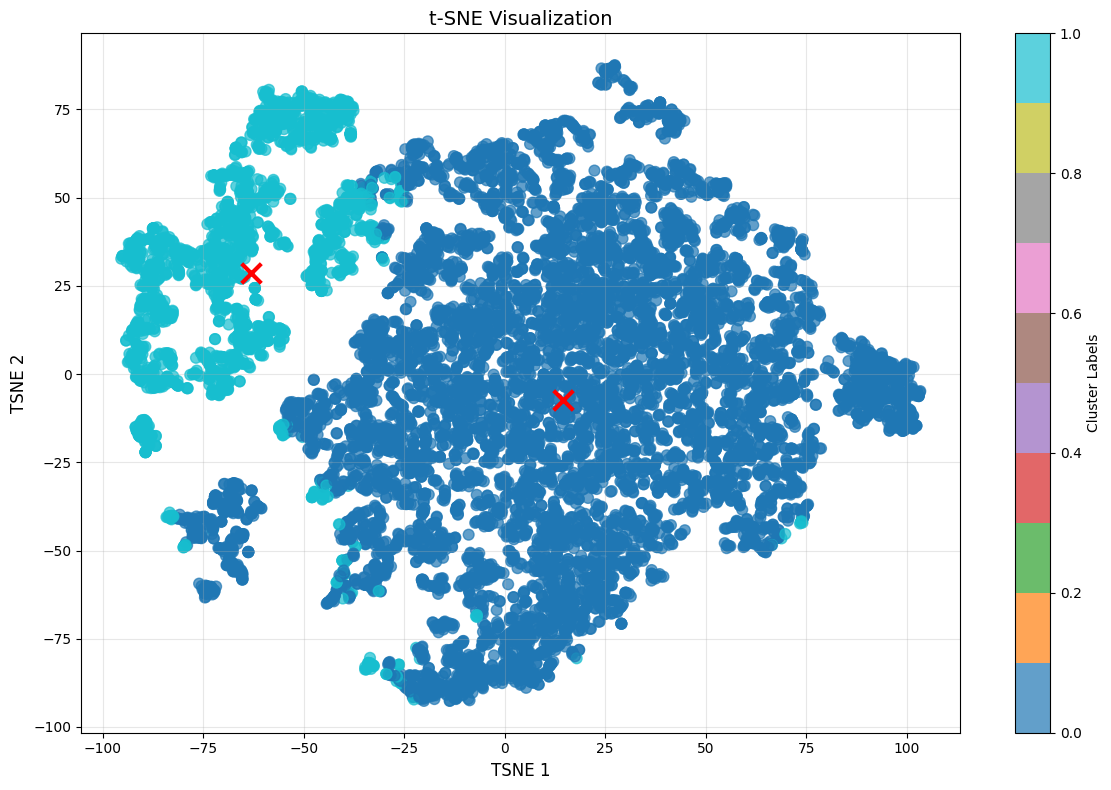

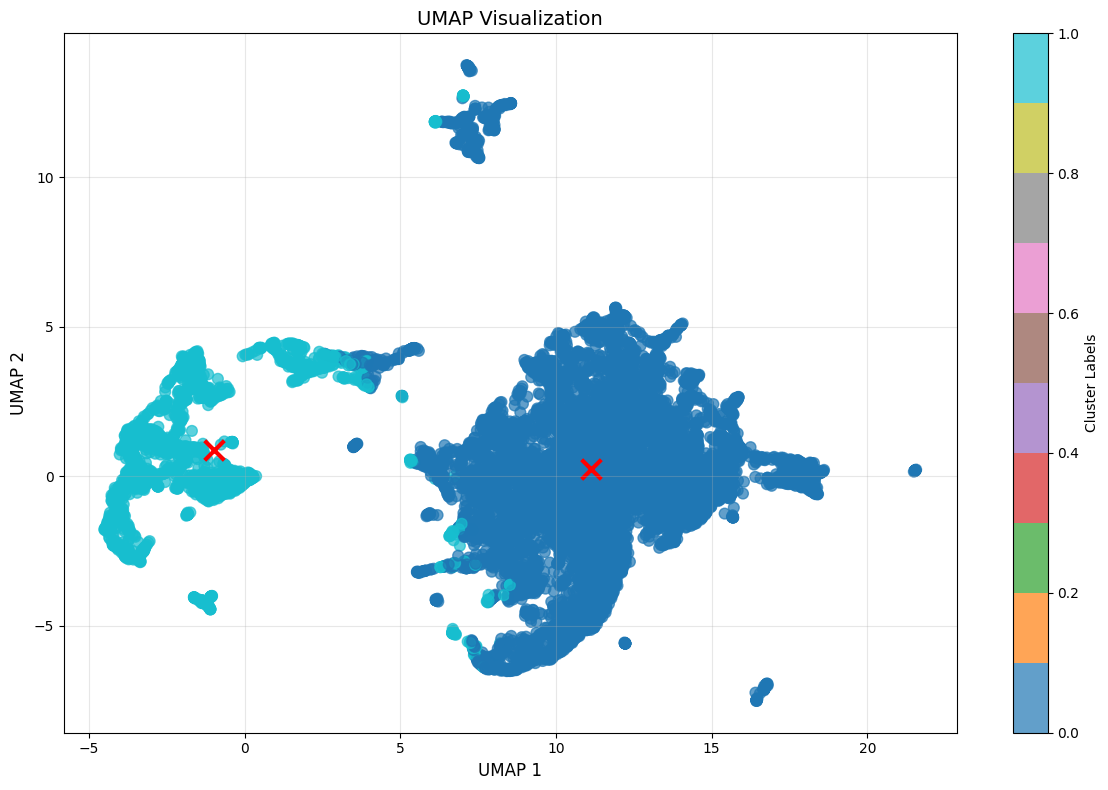


=== Optimized K-means Analysis ===
Number of clusters: 2
Cluster 0: 10062 samples (81.3%)
Cluster 1: 2313 samples (18.7%)

Cluster composition by Kingdom:
Kingdom  arc   bct   inv   mam  phg  plm   pln  pri  rod   vrl   vrt
Cluster                                                             
0        1.3  28.7   9.3   1.0  2.2  0.2  23.6  0.8  0.6  28.0   4.5
1        0.0   1.3  15.9  16.7  0.0  0.0   6.6  4.1  5.2   0.5  49.7

=== STEP 3: SAVING CLUSTERING RESULTS ===
Saved clustering results to hasil_clustering.csv

=== STEP 4: PREPARING FOR CLASSIFICATION ===
Loaded clustered data: (12375, 70)
Cluster distribution:
Cluster
0    10062
1     2313
Name: count, dtype: int64


In [102]:
# USAGE EXAMPLE - COMPLETE PIPELINE
# ===============================
from joblib import dump
# Karena dataset codon_data sudah ada, langsung jalankan pipeline lengkap:

# Step 1: Initialize clustering pipeline
print("=== STEP 1: CLUSTERING ===")
pipeline = ImprovedCodonClusteringPipeline(codon_data)
best_labels, best_score, best_params = pipeline.full_pipeline(optimize_params=True)
features_log = pipeline.features_log
dump(features_log, "features_log.pkl")
print("features_log.pkl saved!")

# Step 2: Visualize clustering results
print("\n=== STEP 2: CLUSTERING VISUALIZATION ===")
pipeline.visualize_clusters(labels=best_labels, method='tsne')
pipeline.visualize_clusters(labels=best_labels, method='umap')
pipeline.analyze_clusters(best_labels, "Optimized K-means")

# Step 3: Save clustering results
print("\n=== STEP 3: SAVING CLUSTERING RESULTS ===")
save_cluster_results(pipeline.codon_data, best_labels, "hasil_clustering.csv", cluster_col_name="Cluster")

# Step 4: Load results for classification
print("\n=== STEP 4: PREPARING FOR CLASSIFICATION ===")
results = pd.read_csv("hasil_clustering.csv")
print(f"Loaded clustered data: {results.shape}")
print(f"Cluster distribution:")
print(results['Cluster'].value_counts().sort_index())

In [103]:
# Usage example after your pipeline run:
metrics = evaluate_clustering(pipeline.X_pca, best_labels)

=== CLUSTERING EVALUATION METRICS ===
Silhouette Score       : 0.5187
Davies-Bouldin Index   : 0.9436
Calinski-Harabasz Index: 6797.7414
Cluster size distribution:
0    10062
1     2313
dtype: int64


In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix




=== STARTING FULL CLASSIFICATION PIPELINE ===
=== PREPARING CLASSIFICATION DATA ===
Feature shape: (11785, 54)
Target distribution:
Cluster
0    9861
1    1924
Name: count, dtype: int64

=== RUNNING MULTIPLE CLASSIFIERS ===

Training Random Forest...
Random Forest - Accuracy: 0.9084, CV: 0.8971 (+/- 0.0086)

Training XGBoost...
XGBoost - Accuracy: 0.8935, CV: 0.8912 (+/- 0.0092)

Training SVM...
SVM - Accuracy: 0.8876, CV: 0.8807 (+/- 0.0107)

Training Logistic Regression...
Logistic Regression - Accuracy: 0.8884, CV: 0.8779 (+/- 0.0138)

=== OPTIMIZING BEST CLASSIFIER ===
Best classifier: Random Forest
Optimizing Random Forest with 20 randomized search iterations...
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
Optimized accuracy: 0.9079

=== EXTRACTING TOP 20 FEATURE IMPORTANCE ===

Random Forest - Top 20 Important Features:
                    Feature  Importance
51          kingdom_encoded    0.143521
32   charged_negative_u

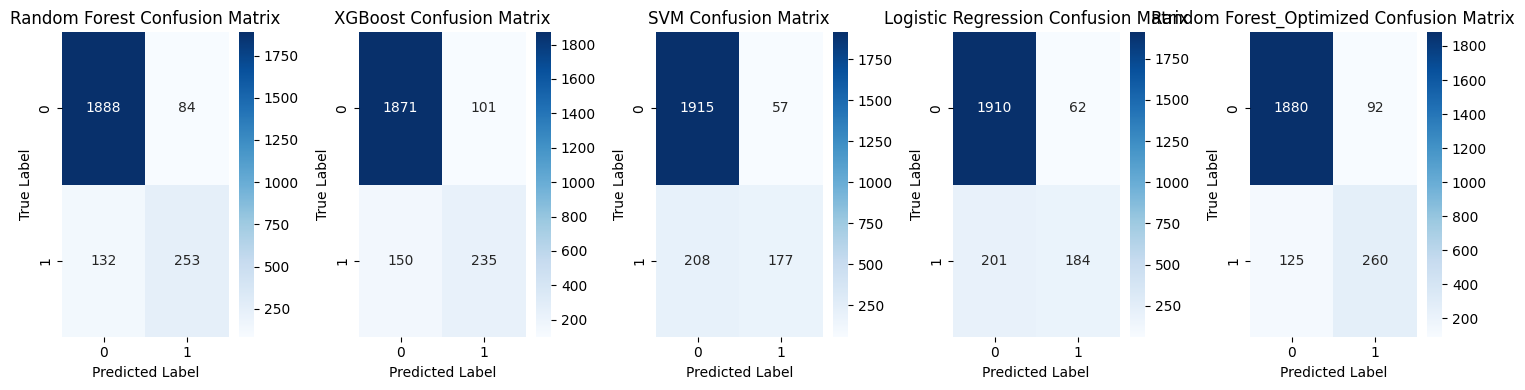


=== SAVING CLASSIFICATION RESULTS to classification_results ===
Saved classification_results/random_forest_feature_importance.csv
Saved classification_results/xgboost_feature_importance.csv
Saved classification_results/logistic_regression_feature_importance.csv
Saved classification_results/random_forest_optimized_feature_importance.csv
Saved classification_results/cluster_characteristics_analysis.csv
Saved classification_results/model_comparison_summary.csv
Saving complete.

=== FULL CLASSIFICATION PIPELINE COMPLETED ===

=== PIPELINE COMPLETED SUCCESSFULLY ===
Generated files:
- hasil_clustering.csv (species with cluster labels)
- classification_results_*_feature_importance.csv
- classification_results_cluster_analysis.csv
- classification_results_model_comparison.csv

All visualizations have been displayed above!


In [105]:
classifier = CodonClassificationPipeline(results, pipeline)
classifier.full_classification_pipeline(test_size=0.2, optimize=True, top_features=20)

In [157]:
# Load cluster analysis
cluster_df = pd.read_csv("hasil_clustering.csv")
cluster_analysis = pd.read_csv("classification_results/cluster_characteristics_analysis.csv")
# Load feature importance (misal Random Forest)
importance_df = pd.read_csv("classification_results/random_forest_feature_importance.csv")

In [148]:
cluster_df

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA,Cluster
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000,0
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000,0
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144,0
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000,0
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12370,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638,0
12371,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887,1
12372,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017,1
12373,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156,0


In [158]:
cluster_analysis

,Cluster,Size,Top_Features_Mean
0,0,9861,"enc_approx:2.8636, entropy:1.6328, kingdom_enc..."
1,1,1924,"enc_approx:2.8162, kingdom_encoded:1.9888, ent..."


In [125]:
importance_df

,Feature,Importance
0,kingdom_encoded,0.143521
1,charged_negative_usage,0.056675
2,L,0.043269
3,E,0.036056
4,charged_positive_usage,0.032085
5,D,0.028460
6,hydrophobic_usage,0.027704
7,R,0.024097
8,entropy,0.021657
9,cos_sim_mam,0.019793


In [160]:
# Mapping dictionary
feature_description_full = {
    'kingdom_encoded': {
        'description': 'Kingdom Taxonomy Label',
        'detail': 'Encoded label representing the taxonomic kingdom (e.g., Bacteria, Archaea, Eukaryota). Often used as a categorical identifier in classification tasks.'
    },
    'charged_negative_usage': {
        'description': 'Usage of Negatively Charged Amino Acids',
        'detail': 'Indicates the codon usage frequency for negatively charged amino acids like Aspartic acid (D) and Glutamic acid (E). High values may suggest adaptation for acidic protein functions.'
    },
    'charged_positive_usage': {
        'description': 'Usage of Positively Charged Amino Acids',
        'detail': 'Reflects the preference in using codons for basic amino acids such as Lysine (K), Arginine (R), and Histidine (H). Relevant in proteins involved in nucleic acid interactions.'
    },
    'hydrophobic_usage': {
        'description': 'Hydrophobic Amino Acid Usage',
        'detail': 'Frequency of codons coding for hydrophobic amino acids, often found in membrane-spanning regions or protein cores.'
    },
    'entropy': {
        'description': 'Codon Usage Entropy (Diversity)',
        'detail': 'Measures how evenly codons are used across synonymous options. Lower entropy indicates stronger bias, which may be linked to high expression efficiency.'
    },
    'mean_gini_interaction': {
        'description': 'Mean Gini Codon Interaction',
        'detail': 'Represents average inequality in codon usage interactions across features. Higher values imply more bias or selection in codon usage.'
    },
    'std': {
        'description': 'Standard Deviation of Codon Usage',
        'detail': 'Measures variability in codon usage frequencies. High values suggest heterogeneity in codon preference across the genome.'
    },
    'skewness': {
        'description': 'Skewness of Codon Usage',
        'detail': 'Indicates asymmetry in codon usage distribution. Positive or negative skew can reflect selection pressure or mutational bias.'
    },
    'kurtosis': {
        'description': 'Kurtosis of Codon Usage',
        'detail': 'Reflects peakedness or flatness of codon usage distribution. May reveal codon usage extremity in specific genomes.'
    },
    'entropy_std_interaction': {
        'description': 'Std. of Codon Entropy Interaction',
        'detail': 'Standard deviation of entropy across codon-related interactions, capturing how stable or variable codon diversity is across species or genes.'
    },
    'gini': {
        'description': 'Gini Index of Codon Usage',
        'detail': 'Measures inequality in codon usage. Similar to entropy, but emphasizes skewed distribution. Higher Gini implies stronger codon preference.'
    },
    'polar_entropy': {
        'description': 'Entropy of Polar Amino Acid Usage',
        'detail': 'Quantifies diversity in the usage of codons coding for polar amino acids (e.g., Ser, Thr, Asn). Lower values may indicate specialization in protein interfaces.'
    },
    'special_entropy': {
        'description': 'Entropy of Special Amino Acid Usage',
        'detail': 'Measures the variation in codon usage for amino acids with unique properties (e.g., Proline, Glycine). Useful in identifying structural motifs.'
    },
    'polar_usage': {
        'description': 'Usage of Polar Amino Acids',
        'detail': 'Reflects how frequently polar amino acids are used. Polar residues are involved in solubility and hydrogen bonding.'
    },
    'special_usage': {
        'description': 'Usage of Special Amino Acids',
        'detail': 'Usage frequency for special amino acids like Glycine, Proline, and Cysteine, which affect protein flexibility and stability.'
    },
    'hydrophobic_entropy': {
        'description': 'Entropy of Hydrophobic Amino Acids',
        'detail': 'Measures diversity in usage of hydrophobic amino acids. Important for understanding membrane protein evolution.'
    },
    'cai_approx': {
        'description': 'Codon Adaptation Index (Approx)',
        'detail': 'Approximate measure of how well a gene’s codon usage matches that of highly expressed genes. High CAI suggests translational optimization.'
    },
    'enc_approx': {
        'description': 'Effective Number of Codons (ENC)',
        'detail': 'Estimates how evenly synonymous codons are used. Lower ENC values indicate stronger codon bias.'
    },
    'cos_sim_mam': {
        'description': 'Cosine Similarity to Mammals',
        'detail': 'Similarity of codon usage profile to mammalian species. Higher values suggest convergent evolutionary pressures or horizontal gene transfer.'
    },
    'cos_sim_vrt': {
        'description': 'Cosine Similarity to Vertebrates',
        'detail': 'Degree of similarity between species codon usage and vertebrates. Can be used to infer evolutionary proximity or codon mimicry.'
    },
    'cos_sim_vrl': {
        'description': 'Cosine Similarity to Viruses (Large)',
        'detail': 'Indicates how closely codon usage matches that of large viruses. Useful for detecting viral mimicry or co-evolution.'
    },
    'cos_sim_rod': {
        'description': 'Cosine Similarity to Rodents',
        'detail': 'Codon usage similarity to rodent species like mice. May indicate shared translational constraints or genomic mimicry.'
    },
    'cos_sim_plm': {
        'description': 'Cosine Similarity to Plants (Monocots)',
        'detail': 'Measures resemblance to monocotyledonous plant codon usage (e.g., rice, wheat). Useful in gene transfer and synthetic biology contexts.'
    },
    'cos_sim_pri': {
        'description': 'Cosine Similarity to Primates',
        'detail': 'Similarity score to primate codon usage profiles, such as human or chimpanzee.'
    },
    'cos_sim_phg': {
        'description': 'Cosine Similarity to Phages',
        'detail': 'Codon usage similarity to bacteriophages. High similarity may indicate phage infection or adaptation.'
    },
    'cos_sim_arc': {
        'description': 'Cosine Similarity to Archaea',
        'detail': 'Resemblance to codon usage patterns found in Archaea. May suggest horizontal gene transfer or extremophile adaptation.'
    },
    'cos_sim_bct': {
        'description': 'Cosine Similarity to Bacteria',
        'detail': 'Reflects how close codon usage is to bacterial species. Often high in prokaryotic genomes or symbiotic eukaryotes.'
    },
    'cos_sim_pln': {
        'description': 'Cosine Similarity to Plants',
        'detail': 'Similarity to general plant codon usage, encompassing both monocots and dicots.'
    },
    'cos_sim_inv': {
        'description': 'Cosine Similarity to Invertebrates',
        'detail': 'Used to evaluate alignment of codon preferences with invertebrate species.'
    },
    'cosine_similarity_to_median': {
        'description': 'Cosine Similarity to Median Codon Profile',
        'detail': 'How close the codon usage of a species is to the median profile across all species. Can reveal outlier behavior or typicality.'
    },
    'cosine_similarity_to_mean': {
        'description': 'Cosine Similarity to Mean Codon Profile',
        'detail': 'Measures alignment with average codon usage. Useful for detecting deviation from the global codon trend.'
    },
    'charged_positive_entropy': {
        'description': 'Entropy of Positively Charged Amino Acid Codon Usage',
        'detail': 'Captures diversity in codon usage for K, R, H. Lower entropy implies stronger bias, possibly due to translational optimization.'
    },
    'charged_negative_entropy': {
        'description': 'Entropy of Negatively Charged Amino Acid Codon Usage',
        'detail': 'Diversity measure for D, E codon usage. High entropy means more varied codon usage; low may indicate selection for efficiency.'
    },
    'A': {
        'description': 'Alanine (A)',
        'detail': 'Codon usage frequency for the amino acid Alanine. Often found in alpha-helices and involved in protein flexibility.'
    },
    'C': {
        'description': 'Cysteine (C)',
        'detail': 'Codon usage frequency for the amino acid Cysteine. Important for disulfide bonds and structural stability of proteins.'
    },
    'D': {
        'description': 'Aspartic Acid (D)',
        'detail': 'Codon usage frequency for the amino acid Aspartic Acid. Negatively charged, often found in active sites or catalytic residues.'
    },
    'E': {
        'description': 'Glutamic Acid (E)',
        'detail': 'Codon usage frequency for the amino acid Glutamic Acid. Negatively charged, involved in protein solubility and enzyme activity.'
    },
    'F': {
        'description': 'Phenylalanine (F)',
        'detail': 'Codon usage frequency for the amino acid Phenylalanine. Aromatic and hydrophobic, contributes to protein core structure.'
    },
    'G': {
        'description': 'Glycine (G)',
        'detail': 'Codon usage frequency for the amino acid Glycine. The smallest amino acid, often found in tight turns and flexible regions.'
    },
    'H': {
        'description': 'Histidine (H)',
        'detail': 'Codon usage frequency for the amino acid Histidine. Positively charged at physiological pH and crucial in metal binding and catalysis.'
    },
    'I': {
        'description': 'Isoleucine (I)',
        'detail': 'Codon usage frequency for the amino acid Isoleucine. Hydrophobic, frequently located in the interior of proteins.'
    },
    'K': {
        'description': 'Lysine (K)',
        'detail': 'Codon usage frequency for the amino acid Lysine. Positively charged, important for interactions with DNA and other molecules.'
    },
    'L': {
        'description': 'Leucine (L)',
        'detail': 'Codon usage frequency for the amino acid Leucine. A common hydrophobic residue found in protein cores.'
    },
    'M': {
        'description': 'Methionine (M)',
        'detail': 'Codon usage frequency for the amino acid Methionine. The universal start codon, also involved in methyl group transfers.'
    },
    'N': {
        'description': 'Asparagine (N)',
        'detail': 'Codon usage frequency for the amino acid Asparagine. Polar and often glycosylated in proteins.'
    },
    'P': {
        'description': 'Proline (P)',
        'detail': 'Codon usage frequency for the amino acid Proline. Unique cyclic structure, often introduces kinks in protein chains.'
    },
    'Q': {
        'description': 'Glutamine (Q)',
        'detail': 'Codon usage frequency for the amino acid Glutamine. Polar, involved in nitrogen metabolism and signaling.'
    },
    'R': {
        'description': 'Arginine (R)',
        'detail': 'Codon usage frequency for the amino acid Arginine. Positively charged, often interacts with phosphate backbones and active sites.'
    },
    'S': {
        'description': 'Serine (S)',
        'detail': 'Codon usage frequency for the amino acid Serine. Polar, frequently involved in phosphorylation and enzymatic functions.'
    },
    'T': {
        'description': 'Threonine (T)',
        'detail': 'Codon usage frequency for the amino acid Threonine. Polar and often phosphorylated in signaling proteins.'
    },
    'V': {
        'description': 'Valine (V)',
        'detail': 'Codon usage frequency for the amino acid Valine. Hydrophobic, typically buried inside proteins.'
    },
    'W': {
        'description': 'Tryptophan (W)',
        'detail': 'Codon usage frequency for the amino acid Tryptophan. Aromatic, involved in protein-protein interactions and fluorescence.'
    },
    'Y': {
        'description': 'Tyrosine (Y)',
        'detail': 'Codon usage frequency for the amino acid Tyrosine. Aromatic and polar, often involved in signaling via phosphorylation.'
    },
    'median': {
    'description': 'Median Codon Usage Value',
    'detail': 'The median of codon usage frequencies across all codons for a species. Represents the central tendency and is less sensitive to outliers than the mean.'
}
}

In [161]:
def map_feature_metadata(df, feature_col='Feature',
                         description_col='Feature Description',
                         detail_col='Feature Detail',
                         metadata_dict=None):
    """
    Menambahkan deskripsi dan detail fitur ke dataframe berdasarkan dictionary metadata.

    Parameters:
        df (pd.DataFrame): Dataframe yang ingin diperkaya.
        feature_col (str): Nama kolom fitur yang ingin dipetakan.
        description_col (str): Nama kolom output untuk deskripsi fitur.
        detail_col (str): Nama kolom output untuk detail fitur.
        metadata_dict (dict): Dictionary berisi mapping fitur ke 'description' dan 'detail'.

    Returns:
        pd.DataFrame: Salinan dataframe dengan dua kolom baru: deskripsi dan detail fitur.
    """
    if metadata_dict is None:
        raise ValueError("metadata_dict harus diberikan!")

    df = df.copy()
    df[description_col] = df[feature_col].map(
        lambda x: metadata_dict.get(x, {}).get('description', x)
    )
    df[detail_col] = df[feature_col].map(
        lambda x: metadata_dict.get(x, {}).get('detail', '')
    )
    return df

In [162]:
importance_df = map_feature_metadata(
    importance_df,
    feature_col='Feature',
    metadata_dict=feature_description_full
)

In [163]:
importance_df

,Feature,Importance,Feature Description,Feature Detail
0,kingdom_encoded,0.143521,Kingdom Taxonomy Label,Encoded label representing the taxonomic kingd...
1,charged_negative_usage,0.056675,Usage of Negatively Charged Amino Acids,Indicates the codon usage frequency for negati...
2,L,0.043269,Leucine (L),Codon usage frequency for the amino acid Leuci...
3,E,0.036056,Glutamic Acid (E),Codon usage frequency for the amino acid Gluta...
4,charged_positive_usage,0.032085,Usage of Positively Charged Amino Acids,Reflects the preference in using codons for ba...
5,D,0.028460,Aspartic Acid (D),Codon usage frequency for the amino acid Aspar...
6,hydrophobic_usage,0.027704,Hydrophobic Amino Acid Usage,Frequency of codons coding for hydrophobic ami...
7,R,0.024097,Arginine (R),Codon usage frequency for the amino acid Argin...
8,entropy,0.021657,Codon Usage Entropy (Diversity),Measures how evenly codons are used across syn...
9,cos_sim_mam,0.019793,Cosine Similarity to Mammals,Similarity of codon usage profile to mammalian...


In [171]:
def extract_labeled_cluster_features(cluster_analysis, importance_df, cluster_df):
    records = []
    for _, row in cluster_analysis.iterrows():
        cluster = row['Cluster']
        feature_items = row['Top_Features_Mean'].split(',')
        for item in feature_items:
            if ':' in item:
                feat, val = item.strip().split(':')
                records.append({'Cluster': cluster, 'Feature': feat.strip()})

    # DataFrame berisi fitur dominan per cluster
    parsed_df = pd.DataFrame(records)

    # Gabungkan dengan deskripsi fitur
    final_labeled = parsed_df.merge(
        importance_df[['Feature', 'Importance', 'Feature Description', 'Feature Detail']],
        on='Feature',
        how='left'
    )

    # Hitung jumlah spesies per Kingdom dan Cluster
    cluster_meta = cluster_df.groupby(['Cluster', 'Kingdom']).size().reset_index(name='n_species')

    # Gabungkan informasi Kingdom dan n_species ke hasil akhir
    final_output = final_labeled.merge(cluster_meta, on='Cluster', how='left')

    # Susun ulang kolom sesuai urutan yang diinginkan
    final_output = final_output[
        ['Cluster', 'n_species', 'Kingdom', 'Feature', 'Importance', 'Feature Description', 'Feature Detail']
    ]

    return final_output

final_labeled_df = extract_labeled_cluster_features(cluster_analysis, importance_df, cluster_df)
display(final_labeled_df)

,Cluster,n_species,Kingdom,Feature,Importance,Feature Description,Feature Detail
0,0,126,arc,enc_approx,0.010233,Effective Number of Codons (ENC),Estimates how evenly synonymous codons are use...
1,0,2889,bct,enc_approx,0.010233,Effective Number of Codons (ENC),Estimates how evenly synonymous codons are use...
2,0,932,inv,enc_approx,0.010233,Effective Number of Codons (ENC),Estimates how evenly synonymous codons are use...
3,0,101,mam,enc_approx,0.010233,Effective Number of Codons (ENC),Estimates how evenly synonymous codons are use...
4,0,220,phg,enc_approx,0.010233,Effective Number of Codons (ENC),Estimates how evenly synonymous codons are use...
...,...,...,...,...,...,...,...
185,1,152,pln,skewness,0.017501,Skewness of Codon Usage,Indicates asymmetry in codon usage distributio...
186,1,94,pri,skewness,0.017501,Skewness of Codon Usage,Indicates asymmetry in codon usage distributio...
187,1,121,rod,skewness,0.017501,Skewness of Codon Usage,Indicates asymmetry in codon usage distributio...
188,1,12,vrl,skewness,0.017501,Skewness of Codon Usage,Indicates asymmetry in codon usage distributio...


In [173]:
final_labeled_df.to_csv("kingdom_cluster_feature_insight.csv")

In [174]:
from google.colab import files
files.download("kingdom_cluster_feature_insight.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>